In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_tranforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "./data/beef"
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                        data_tranforms[x])
                                        for x in ['train', 'val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],
                                            batch_size=4,
                                            shuffle=True,
                                            num_workers=4)
                                            for x in ['train', 'val']}
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



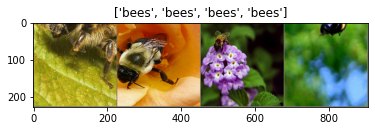

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out,title=[class_names[x] for x in classes])
    

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epock{}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:

            # 设置模型的状态
            if phase == 'train':
                model.train()
            else:
                model.eval()

            runnning_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                runnning_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = runnning_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_as_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['var']):
            inputs = inputs.to(device)
            labels = inputs.to(device)

            outputs = model(inputs)
            _,preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_as_far += 1
                ax = plt.subplot(num_img//2, 2, images_as_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_as_far == num_images:
                    model.train(mode=was_training)
                    return
                    
        model.train(mode=was_training)
            
                

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft,exp_lr_scheduler, num_epochs=25)

Epock0/24
----------
train Loss: 0.5394 Acc: 0.7131


KeyboardInterrupt: 

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epock0/24
----------
train Loss: 0.9609 Acc: 0.5451
val Loss: 0.2529 Acc: 0.8954

Epock1/24
----------
train Loss: 0.6476 Acc: 0.7254
val Loss: 0.3799 Acc: 0.8366

Epock2/24
----------
train Loss: 0.4927 Acc: 0.7869
val Loss: 0.1594 Acc: 0.9608

Epock3/24
----------
train Loss: 0.5169 Acc: 0.7992
val Loss: 0.2969 Acc: 0.8889

Epock4/24
----------
train Loss: 0.5286 Acc: 0.8074
val Loss: 0.4421 Acc: 0.8497

Epock5/24
----------
train Loss: 0.5847 Acc: 0.7787
val Loss: 0.2609 Acc: 0.9150

Epock6/24
----------
train Loss: 0.3943 Acc: 0.8115
val Loss: 0.1867 Acc: 0.9412

Epock7/24
----------
train Loss: 0.4061 Acc: 0.8115
val Loss: 0.1917 Acc: 0.9412

Epock8/24
----------
train Loss: 0.3002 Acc: 0.8566
val Loss: 0.2013 Acc: 0.9477

Epock9/24
----------
train Loss: 0.3563 Acc: 0.8361
val Loss: 0.2127 Acc: 0.9477

Epock10/24
----------
train Loss: 0.3812 Acc: 0.8361
val Loss: 0.2528 Acc: 0.9216

Epock11/24
----------
train Loss: 0.2994 Acc: 0.8566
val Loss: 0.1896 Acc: 0.9412

Epock12/24
---